### Детектирование лиц на изображениях. Стрижов Григорий - CS

В данной работе необходимо искать лица на изображениях и выделять их рамочкой. Обучающая выборка состоит из примеров лиц и не лиц.

Я реализовал функции вычисления гистограмм ориентированных градиентов для изображений. Я привёл изображения обучающей выборки к одному размеру. Далее превратил их в вектора при помощи реализованного метода гистограмм. После чего обучил на этих объектах модель, основанную на методе опорных векторов с линейным ядром.

Далее написал функции для поиска лица на изображении из тестовой выборки. Метод заключается в том, что мы обходим всё изображения окном фиксированного размера. Размер берём такой, как у изображений обучающей выборки. В каждом захвате окна делаем предсказание вероятности лицо/не лицо при помощи уже обученной модели. В итоге, если на изображении есть лицо, то вокруг него будет область окон с высоким откликом.

Берём среднее положение этих окон и получаем ответ.

In [1]:
%matplotlib inline
import cv2
import skimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.io import imshow
from skimage.feature import hog
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV as GridSearch
import os

In [2]:
FRAME_WIDTH=24
FRAME_HEIGHT=32

In [3]:
def COMPUTE_HOG(image):
    return hog(image, orientations=9, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=False)


def CREATE_SVC():
    return SVC(kernel = 'linear')


def show_image(image, cmap='gray'):
    plt.imshow(image, cmap=cmap)
    plt.show()

    
def read_image(filename, gray=True):
    if gray:
        return rgb2gray(imread(filename))
    return imread(filename)


def get_train(train, directory, face=1):
    for filename in os.listdir(directory):
        train.append(np.concatenate((COMPUTE_HOG(read_image(directory + filename)), np.array([face])), axis=0))
    return train


def get_patch(image, corner_x, corner_y, width=FRAME_WIDTH, height=FRAME_HEIGHT):
    #print corner_y + height - 1, image.shape[0]
    #print corner_x + width - 1, image.shape[1]
    #if (corner_y + height - 1 < image.shape[0] and corner_x + width - 1 < image.shape[1]):
    return image[corner_y:corner_y + height, corner_x:corner_x + width]
    #return False

    
def plot_patches(image, patchlist, cmap='gray', width=FRAME_WIDTH, height=FRAME_HEIGHT):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=cmap)
    if patchlist is not 'list':
        patchlist = [patchlist]
    for patch in patchlist:
        ax.add_patch(
            patches.Rectangle(
                patch,   # (x,y)
                width,   # width
                height,  # height
                fill=False,
                edgecolor='#26C615',
                linewidth=2,
            )
    )
    
    
def suppose_face_centers(image, classificator, frame_width=FRAME_WIDTH, frame_height=FRAME_HEIGHT):
    centers_matrix = np.zeros((image.shape[0], image.shape[1]))
    for y in xrange(image.shape[0] - frame_height + 1):
        for x in xrange(image.shape[1] - frame_width + 1):
            patch = get_patch(image, x, y)
            patch_hog = COMPUTE_HOG(patch)
            if classificator.predict(patch_hog.reshape(1, -1)):
                centers_matrix[y + FRAME_HEIGHT / 2, x + FRAME_WIDTH / 2] = 1
    return centers_matrix


def get_medium_point(matrix):
    y_mid, x_mid, counter = 0, 0, 0
    for y in xrange(matrix.shape[0]):
        for x in xrange(matrix.shape[1]):
            if matrix[y,x] != 0:
                x_mid += x
                y_mid += y
                counter += 1
    if counter != 0:
        x_mid /= counter
        y_mid /= counter
    return (x_mid, y_mid)
    
    
def get_face(centers_matrix, frame_width=FRAME_WIDTH, frame_height=FRAME_HEIGHT, 
             center_frame_width=FRAME_WIDTH / 4, center_frame_height=FRAME_HEIGHT / 4):
    maximum_density = 0
    for y in xrange(centers_matrix.shape[0] - frame_height + 1):
        for x in xrange(centers_matrix.shape[1] - frame_width + 1):
            center_patch = get_patch(centers_matrix, x, y, center_frame_width, center_frame_height)
            centers_number = np.count_nonzero(center_patch)
            if centers_number > maximum_density:
                maximum_density = centers_number
                best_center_patch = center_patch
                xy = (x, y)
    mid_point = get_medium_point(best_center_patch)
    mid_point = (mid_point[0] + xy[0], mid_point[1] + xy[1])
    face = (mid_point[0] - frame_width / 2, mid_point[1] - frame_height / 2)
    return face


def show_face(image_name, classificator):
    image = read_image(image_name)
    face = get_face(suppose_face_centers(image, classificator))
    image = read_image(image_name, gray=False)
    plot_patches(image, face)

### Подбор параметров и обучение классификатора:
pixels_per_cell выбираю так, чтобы визуализация HOG была похожа на лицо:

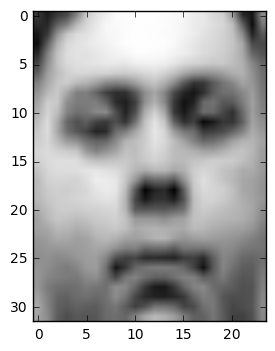

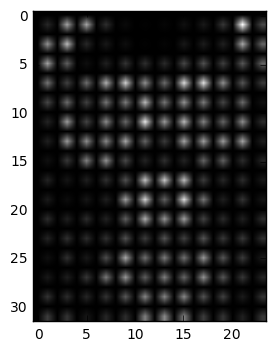

In [4]:
image = read_image('train/faces/5.png')
testhog = hog(image, orientations=9, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=True)
show_image(image)
show_image(testhog[1])

In [5]:
train = []
train = get_train(train, 'train/faces/')
train = get_train(train, 'train/non-faces/', face=0)
nptrain = np.random.permutation(np.array(train))
print nptrain.shape

(3216, 1729)


In [6]:
svc = SVC(kernel = 'linear', C = 0.08)
parameters = {'C':[0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 
                   0.001,  0.003, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 1]}
clf = GridSearch(svc, parameters, n_jobs = -1)

In [7]:
clf.fit(nptrain[:,:-1], nptrain[:,-1])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=0.08, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.0001, 0.0003, 0.0005, 0.0007, 0.0009, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [8]:
print clf.best_params_

{'C': 0.01}


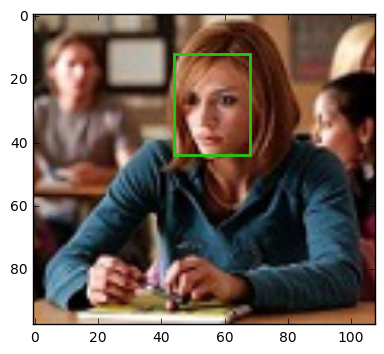

In [9]:
show_face('test/1.jpg', clf)

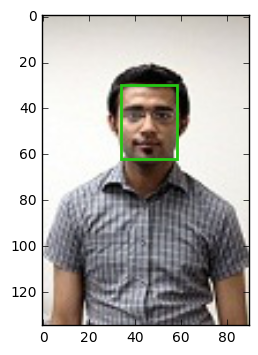

In [10]:
show_face('test/2.jpg', clf)

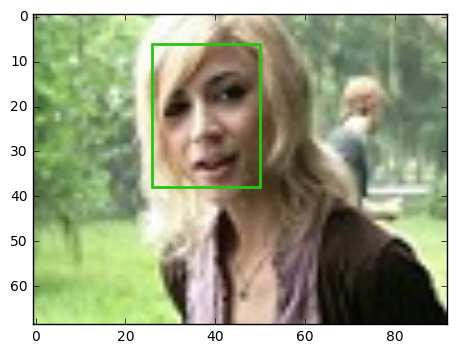

In [11]:
show_face('test/3.jpg', clf)

Ложное срабатывание:

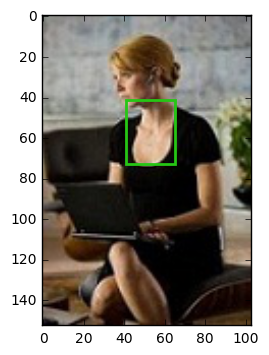

In [12]:
show_face('test/4.jpg', clf)

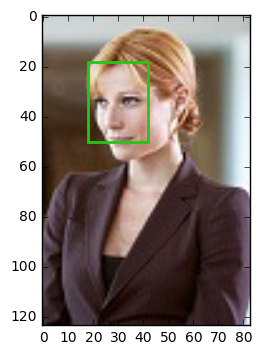

In [13]:
show_face('test/5.jpg', clf)

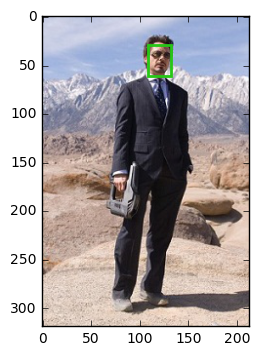

In [14]:
show_face('test/6.jpg', clf)

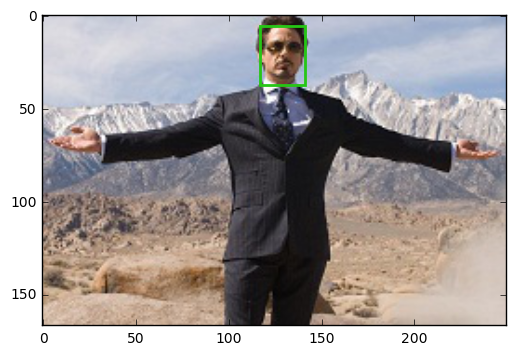

In [15]:
show_face('test/7.jpg', clf)

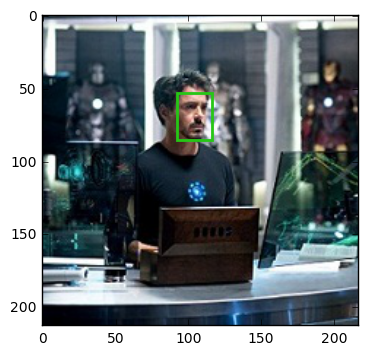

In [16]:
show_face('test/8.jpg', clf)

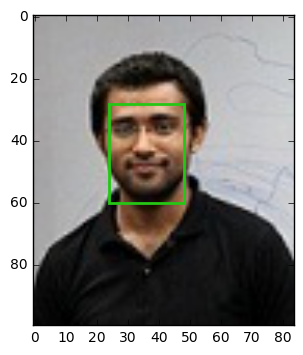

In [17]:
show_face('test/9.jpg', clf)